In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Input, GlobalMaxPooling1D
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize, OneHotEncoder

## Nacitanie

In [ ]:
dataset = pd.read_csv('../Data/final_dataset_3.csv')

In [ ]:
dataset.shape

(1951, 2)

## Rozdelenie dat na sady

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
print(X_train[:10])

391     hatred cast thought reach sea many blossoms op...
1518    niece sir w batten come great content without ...
95      stayed day without food drink follering came d...
1072    afterward bunny brown sister sue learned goat ...
760     daur ye speyk gait aboot yer sonay mine mair g...
1312    twice began-twice voice failed last words came...
1280    immense ruin spot earth man feels significance...
465     half dozen pounds tea weigh couple bottles spi...
601     admiral curling whiskers sent castle inquire b...
903     natives believe lighted tar-barrels cordon san...
Name: processed_text, dtype: object


## One hot encoding

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

In [ ]:
print(y_valid)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


# TextVectorization

## Model 1

In [ ]:
embedding_dim = 256
vocab_size = 60000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
input_layer = Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(x_v)
x = tf.keras.layers.Conv1D(512, kernel_size=4, padding="valid", activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 6000, 256)         15360000  
                                                                 
 conv1d (Conv1D)             (None, 5997, 512)         524800    
                                                                 
 max_pooling1d (MaxPooling1  (None, 2998, 512)         0         
 D)                                                              
                                                                 
 global_average_pooling1d (  (None, 512)               0     

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size = 32, callbacks=[model_checkpoint_callback])

Epoch 1/10
44/44 [==============================] - 23s 326ms/step - loss: 2.7541 - accuracy: 0.1531 - val_loss: 2.5703 - val_accuracy: 0.2051
Epoch 2/10
44/44 [==============================] - 11s 249ms/step - loss: 2.0447 - accuracy: 0.3419 - val_loss: 1.7389 - val_accuracy: 0.4744
Epoch 3/10
44/44 [==============================] - 11s 253ms/step - loss: 1.4197 - accuracy: 0.5534 - val_loss: 1.1846 - val_accuracy: 0.6731
Epoch 4/10
44/44 [==============================] - 11s 256ms/step - loss: 0.8811 - accuracy: 0.7358 - val_loss: 0.8212 - val_accuracy: 0.7436
Epoch 5/10
44/44 [==============================] - 11s 260ms/step - loss: 0.5433 - accuracy: 0.8440 - val_loss: 0.5659 - val_accuracy: 0.8654
Epoch 6/10
44/44 [==============================] - 12s 263ms/step - loss: 0.3275 - accuracy: 0.9231 - val_loss: 0.3506 - val_accuracy: 0.9167
Epoch 7/10
44/44 [==============================] - 11s 261ms/step - loss: 0.2060 - accuracy: 0.9594 - val_loss: 0.3215 - val_accuracy: 0.9167

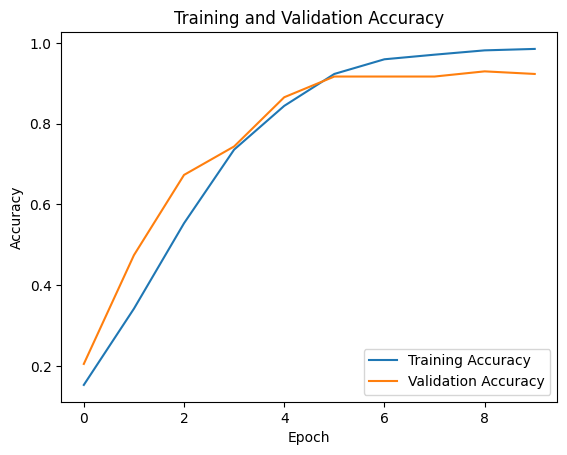

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

13/13 [==============================] - 1s 84ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.9360613810741688
F1 Score: 0.9373294588471168
Precision: 0.9464605217426038
Recall: 0.9360613810741688


## Model 2

In [ ]:
embedding_dim = 512
vocab_size = 100000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
input_layer = Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(x_v)
x = tf.keras.layers.Conv1D(512, kernel_size=4, padding="valid", activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(256, kernel_size=4, padding="valid", activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_4 (Text  (None, 6000)              0         
 Vectorization)                                                  
                                                                 
 embedding_5 (Embedding)     (None, 6000, 512)         51200000  
                                                                 
 conv1d_9 (Conv1D)           (None, 5997, 512)         1049088   
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 2998, 512)         0         
 g1D)                                                            
                                                                 
 conv1d_10 (Conv1D)          (None, 2995, 256)         5245

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/10
176/176 [==============================] - 30s 162ms/step - loss: 2.5123 - accuracy: 0.1624 - val_loss: 2.0245 - val_accuracy: 0.3077
Epoch 2/10
176/176 [==============================] - 28s 160ms/step - loss: 1.4918 - accuracy: 0.4758 - val_loss: 1.4167 - val_accuracy: 0.5385
Epoch 3/10
176/176 [==============================] - 28s 160ms/step - loss: 1.0308 - accuracy: 0.6289 - val_loss: 1.1462 - val_accuracy: 0.5705
Epoch 4/10
176/176 [==============================] - 28s 159ms/step - loss: 0.6810 - accuracy: 0.7699 - val_loss: 0.8768 - val_accuracy: 0.7179
Epoch 5/10
176/176 [==============================] - 26s 149ms/step - loss: 0.5469 - accuracy: 0.8212 - val_loss: 1.1905 - val_accuracy: 0.6282
Epoch 6/10
176/176 [==============================] - 28s 156ms/step - loss: 0.3997 - accuracy: 0.8775 - val_loss: 0.8383 - val_accuracy: 0.7885
Epoch 7/10
176/176 [==============================] - 28s 158ms/step - loss: 0.3360 - accuracy: 0.8917 - val_loss: 0.7189 - val_ac

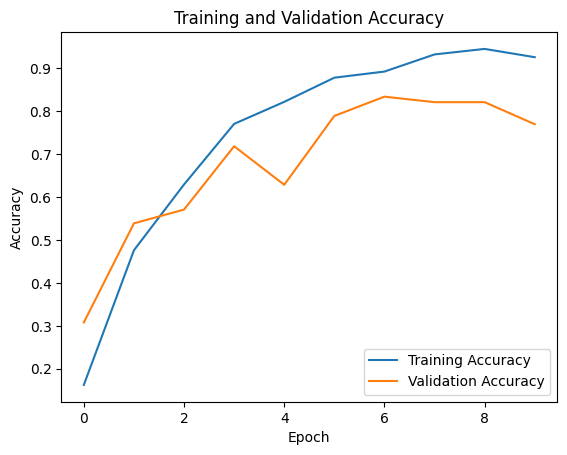

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

13/13 [==============================] - 2s 152ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.7749360613810742
F1 Score: 0.7814525927524644
Precision: 0.8189029429651833
Recall: 0.7749360613810742
